In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.multitest import multipletests
from lifelines import CoxTimeVaryingFitter
import cmdstanpy
from cmdstanpy import CmdStanModel
import arviz as az
import os

from multipathogen_sero import (
    simulate_infections,
    simulate_infections_seroreversion,
    simulate_infections_survivor,
    simulate_infections_discrete,
    simulation_to_regression_df,
    simulation_to_survey_wide,
    simulation_to_survey_long,
    survey_long_to_wide,
    get_exponential_foi,
    get_gaussian_foi,
    get_exponential_foi_survivor,
    get_gaussian_foi_survivor
)
from multipathogen_sero.config import PROJ_ROOT, STAN_DIR


2025-08-15 19:57:14.588 | INFO     | multipathogen_sero.config:<module>:12 - PROJ_ROOT path is: /home/ayan/sero/multipathogen-sero


# Simulation
## Simulation parameters

In [3]:
n_people = 10000 #number of individuals n
np.random.seed(42)  # For reproducibility
birth_times = np.random.uniform(0, 100, size=n_people)  # Random birth times for individuals
n_pathogens=12 #number of pathogens K
t_max=100
pathogen_names = [f'Pathogen {i+1}' for i in range(n_pathogens)]  # Names for pathogens
#foi_list = [get_exponential_foi(0, 1) for k, pathogen_name in enumerate(pathogen_names)]
foi_list = [
    get_gaussian_foi(mu=10*k, sigma=30, a=0.05) for k in range(n_pathogens)
]
survivor_list = [
    get_gaussian_foi_survivor(mu=10*k, sigma=30, a=0.05) for k in range(n_pathogens)
]

Text(0.5, 0, 'Time')

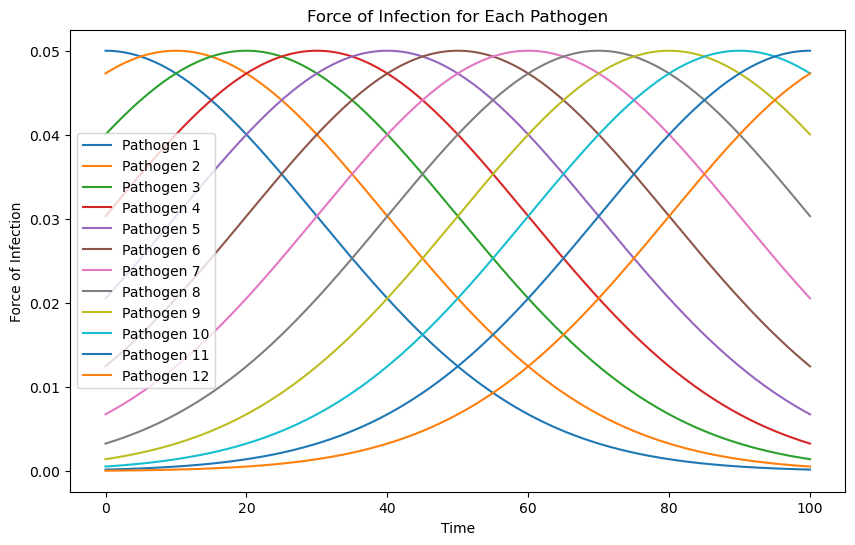

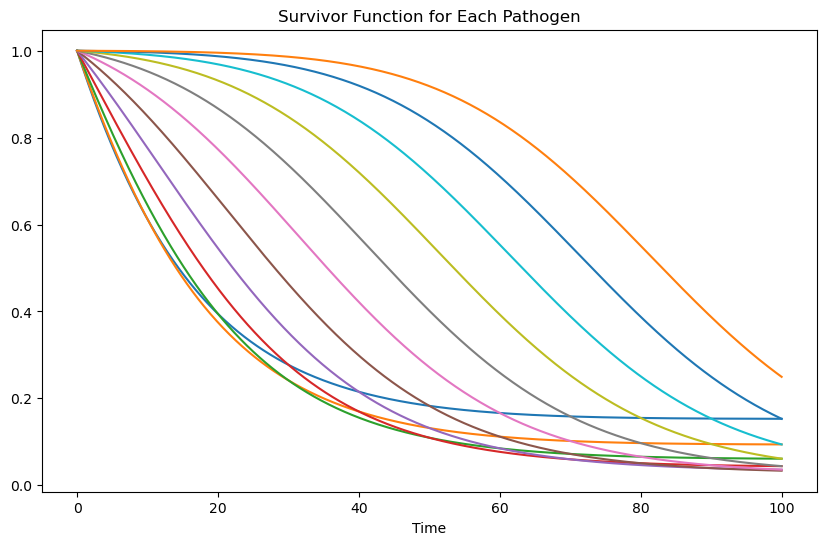

In [4]:
#plot fois
t = np.linspace(0, t_max, 1000)
plt.figure(figsize=(10, 6)) 
for k, foi in enumerate(foi_list):
    plt.plot(t, foi(t), label=pathogen_names[k])
plt.title('Force of Infection for Each Pathogen')
plt.xlabel('Time')
plt.ylabel('Force of Infection')
plt.legend()

#plot survivors
plt.figure(figsize=(10, 6))
for k, survivor in enumerate(survivor_list):
    plt.plot(t, survivor(t), label=pathogen_names[k])
plt.title('Survivor Function for Each Pathogen')
plt.xlabel('Time')

Text(0, 0.5, 'Probability of Infection')

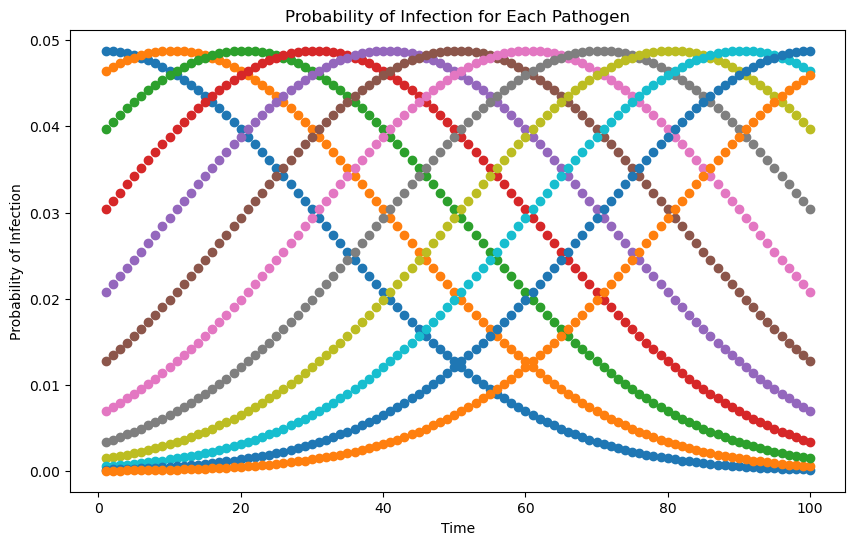

In [5]:
t_grid = np.arange(1, t_max*1 + 1)/1
survivor_grid = np.array([survivor(t_grid) for survivor in survivor_list])
survivor_grid_lagged = np.ones_like(survivor_grid)
survivor_grid_lagged[:, 1:] = survivor_grid[:, :-1]
p_infection = (survivor_grid_lagged - survivor_grid)/survivor_grid_lagged

#plot p_infection
plt.figure(figsize=(10, 6))
for k, p in enumerate(p_infection):
    plt.scatter(t_grid, p, label=pathogen_names[k])
plt.title('Probability of Infection for Each Pathogen')
plt.xlabel('Time')
plt.ylabel('Probability of Infection')

Component 1: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]
Component 2: [6]


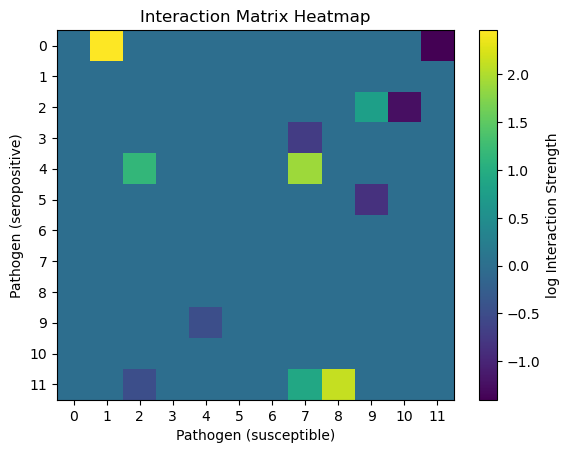

In [6]:
# Interaction matrix

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

# spike and slab on each coefficient of the interaction matrix
np.random.seed(42)  # For reproducibility
interaction_indicator = np.random.binomial(1, 0.1, size=(n_pathogens, n_pathogens))
interaction_indicator[np.arange(n_pathogens), np.arange(n_pathogens)] = 0
beta_mat = np.random.normal(0, 1, size=(n_pathogens, n_pathogens)) * interaction_indicator
interaction_mat = np.exp(beta_mat)
#plot the interaction matrix as a heatmap
plt.imshow(np.log(interaction_mat), cmap='viridis', aspect='auto')
plt.ylabel('Pathogen (seropositive)')
plt.xlabel('Pathogen (susceptible)')
plt.xticks(ticks=np.arange(n_pathogens), labels=np.arange(0, n_pathogens))
plt.yticks(ticks=np.arange(n_pathogens), labels=np.arange(0, n_pathogens))
plt.colorbar(label='log Interaction Strength')
plt.title('Interaction Matrix Heatmap')

# Convert interaction_indicator to a sparse matrix
adj_matrix = csr_matrix(interaction_indicator)

# Find weakly connected components (ignoring direction)
n_components, labels = connected_components(csgraph=adj_matrix, directed=True, connection='weak')

# Group node indices by component
components = [np.where(labels == i)[0] for i in range(n_components)]

for i, comp in enumerate(components):
    print(f"Component {i+1}: {comp.tolist()}")

## Four ways to simulate

In [7]:
start = time.time()
simulate_infections_df = simulate_infections(n_people, n_pathogens, foi_list, interaction_mat, t_max=t_max, birth_times=birth_times, random_seed=42)
print(f"simulate_infections took {time.time() - start:.3f} seconds")

start = time.time()
simulate_infections_df_survivor = simulate_infections_survivor(
    n_people, n_pathogens, survivor_list, interaction_mat, t_max=t_max, birth_times=birth_times, random_seed=42
)
print(f"simulate_infections_survivor took {time.time() - start:.3f} seconds")

start = time.time()
simulate_infections_df_discrete = simulate_infections_discrete(
    n_people, n_pathogens, p_infection, interaction_mat, t_grid=t_grid, birth_times=birth_times, random_seed=42
)
print(f"simulate_infections_discrete took {time.time() - start:.3f} seconds")



simulate_infections took 3.514 seconds
simulate_infections_survivor took 24.381 seconds
simulate_infections_discrete took 1.688 seconds


In [ ]:
start = time.time()
simulate_infections_seroreversion_df = simulate_infections_seroreversion(
    n_people,
    n_pathogens,
    foi_list,
    interaction_mat=interaction_mat,
    seroreversion_rates=None,
    birth_times=birth_times,
    end_times=t_max,
    max_fois=None,
    random_seed=42
)
print(f"simulate_infections_seroreversion took {time.time() - start:.3f} seconds")

simulate_infections_seroreversion took 4.042 seconds


# Checking for validity

## Cox regression

Warning: there can be singular scenarios when e.g. a k=11 infection never comes before a k=0 infection.

Warning: using the discrete simulation, there are tied times, but my implementation treats the records in the df as time-ordered, which will cause a bias.

### Making the dataframe

In [10]:
method_to_validate = 'seroreversion'
if method_to_validate == 'survivor':
    simulation_to_validate = simulate_infections_df_survivor
elif method_to_validate == 'discrete':
    simulation_to_validate = simulate_infections_df_discrete
elif method_to_validate == 'seroreversion':
    simulation_to_validate = simulate_infections_seroreversion_df
else:
    simulation_to_validate = simulate_infections_df


# TODO: replace this block with the function call simulation_to_regression_df

#########################
k_infector = 1       # Infecting pathogen to analyze
n_people_subsample = min(10000, n_people)  # Subsample size for analysis
#########################

regression_df_for_pathogen_k = simulation_to_regression_df(
    simulation_to_validate,
    k_infector=k_infector,  # Set to None to include all pathogens, or specify a specific pathogen index
    t_max=t_max
)
regression_df_for_pathogen_k_subsampled = regression_df_for_pathogen_k[regression_df_for_pathogen_k["individual"]<=n_people_subsample]

### Frequentist Cox regression

Number of individuals in the subsample: 10000
Ground truth effect sizes for pathogen 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Estimated effect sizes for pathogen 1: covariate
serostatus_2    -0.004293
serostatus_3    -0.045675
serostatus_4     0.093184
serostatus_5    -0.041355
serostatus_6     0.019936
serostatus_7     0.034941
serostatus_8    -0.014103
serostatus_9    -0.057784
serostatus_10    0.021420
serostatus_11   -0.020419
serostatus_12    0.157220
dtype: float64
Confidence intervals for pathogen 1:                95% lower-bound  95% upper-bound
covariate                                      
serostatus_2         -0.088441         0.079855
serostatus_3         -0.134139         0.042789
serostatus_4          0.009457         0.176912
serostatus_5         -0.137562         0.054852
serostatus_6         -0.069068         0.108941
serostatus_7         -0.058015         0.127896
serostatus_8         -0.118062         0.089856
serostatus_9         -0.170876         0.055308
serosta

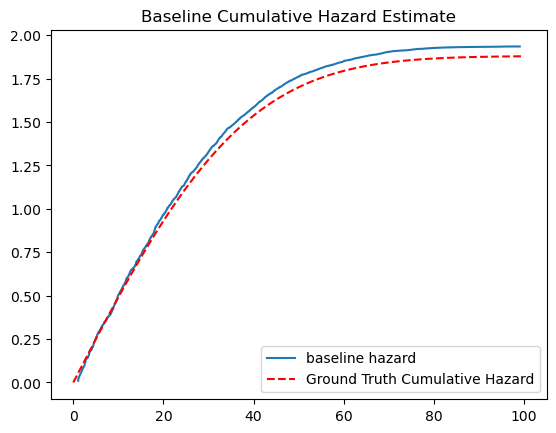

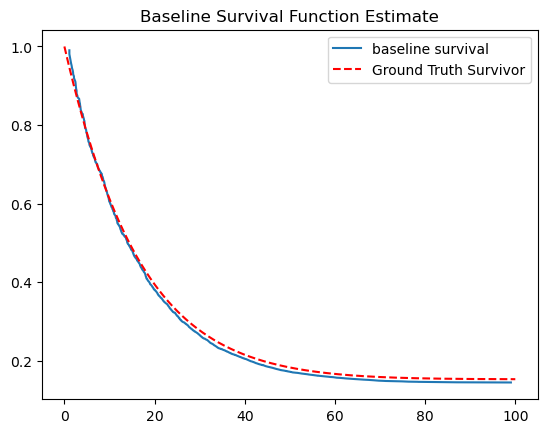

In [11]:
# Instantiate the CoxTimeVaryingFitter
ctv = CoxTimeVaryingFitter()

# Fit the model
ctv.fit(
    regression_df_for_pathogen_k_subsampled,
    id_col = "individual",
    start_col="start_time",
    stop_col="stop_time",
    event_col="event"
)


print(f"Number of individuals in the subsample: {len(regression_df_for_pathogen_k_subsampled['individual'].unique())}")
print(f"Ground truth effect sizes for pathogen {k_infector}: {np.log(interaction_mat[:, k_infector-1])}")
print(f"Estimated effect sizes for pathogen {k_infector}: {ctv.params_}")
print(f"Confidence intervals for pathogen {k_infector}: {ctv.confidence_intervals_}")

# Print summary
# ctv.print_summary()

# Plot baseline cumulative hazard with ground truth cumulative hazard
ax = ctv.baseline_cumulative_hazard_.plot(title="Baseline Cumulative Hazard Estimate")
t_grid = np.linspace(0, t_max, 500)
# Ground truth cumulative hazard: -log(S(t))
S_theoretical = survivor_list[k_infector-1](t_grid)
cumhaz_theoretical = -np.log(S_theoretical)
ax.plot(t_grid, cumhaz_theoretical, label='Ground Truth Cumulative Hazard', color='red', linestyle='--')
ax.legend()

# Plot baseline survival with ground truth survivor
ax2 = ctv.baseline_survival_.plot(title="Baseline Survival Function Estimate")
ax2.plot(t_grid, S_theoretical, label='Ground Truth Survivor', color='red', linestyle='--')
ax2.legend()

### Bayesian Cox regression

In [12]:
# ----------------------------
# 1. Formatting simulated data
# ----------------------------

"""
data {
    int<lower=1> N;                         // Number of individuals
    int<lower=1> P;                         // Number of covariates
    int<lower=1> n_rows;                    // Number of data rows
    vector[n_rows] T_L;                     // Left truncation times
    vector[n_rows] T_R;                     // Right endpoint times (event or censoring)
    array[n_rows] int<lower=0, upper=1> event;    // Event indicator: 1 if event, 0 if right-censored
    array[n_rows] int<lower=1, upper=N> person_id; // Individual ID per row (should be 1-indexed)
    matrix[n_rows, P] X;                    // Covariate matrix
    int<lower=0, upper=2> beta_prior_setting; // 0 for no prior, 1 for Laplace prior, 2 for spike and slab
    real<lower=0> laplace_scale; // scale for Laplace prior when beta_prior_setting == 1
    real<lower=0> slab_scale;    // scale for slab component when beta_prior_setting == 2
    real<lower=0> spike_scale;   // scale for spike component (small) when beta_prior_setting == 2
    real<lower=0, upper=1> pi;   // prior probability of inclusion when beta_prior_setting == 2
}
"""

stan_data = {
    "N": n_people_subsample, # Number of individuals
    "P": n_pathogens - 1, # Number of covariates
    "n_rows": len(regression_df_for_pathogen_k_subsampled), # Number of observation rows
    "T_L": regression_df_for_pathogen_k_subsampled["start_time"].values,
    "T_R": regression_df_for_pathogen_k_subsampled["stop_time"].values,
    "event": regression_df_for_pathogen_k_subsampled["event"].values,
    "person_id": regression_df_for_pathogen_k_subsampled["individual"].values,
    "X": regression_df_for_pathogen_k_subsampled.filter(like='serostatus_').values, # get the data for columns starting with serostatus_
    "beta_prior_setting": 1,
    "laplace_scale": 1,
    "slab_scale": 10,
    "spike_scale": 0.1,
    "pi": 0.1

}

In [13]:
# ----------------------------
# 3. Compile and fit the model
# ----------------------------
model = CmdStanModel(
    stan_file= STAN_DIR / "infection_histories.stan"
)

fit = model.sample(
    data=stan_data,
    chains=4,
    iter_sampling=500,
    iter_warmup=500,
    parallel_chains=4,
    seed=123
)

20:00:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:05:11 - cmdstanpy - INFO - CmdStan done processing.


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.

                         Mean      MCSE    StdDev       MAD            5%  \
lp__            -15116.500000  0.093041  2.463210  2.372160 -15121.100000   
baseline_hazard      0.019955  0.000009  0.000587  0.000597      0.018998   
beta_raw[1]          0.336788  0.000734  0.045016  0.043912      0.261577   
beta_raw[2]          0.258375  0.000793  0.047563  0.046615      0.179447   
beta_raw[3]          0.161517  0.000818  0.044919  0.044684      0.089600   
...                       ...       ...       ...       ...           ...   
log_lik[9996]       -0.0

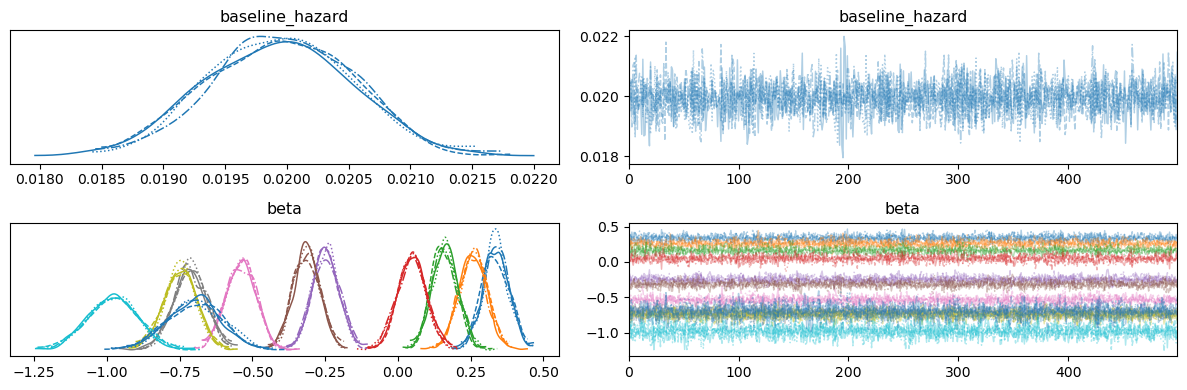

In [14]:

# ----------------------------
# 4. Diagnostics and Summary
# ----------------------------

# Print summary
print(fit.diagnose())
print(fit.summary())

# Check R-hat and ESS
df_summary = fit.summary()
print("Any R-hat > 1.01?", (df_summary["R_hat"] > 1.01).any())
print("Any ESS < 400?", (df_summary["ESS_bulk"] < 400).any())

# Optional: convert to ArviZ for easier plotting
idata = az.from_cmdstanpy(posterior=fit)

# Plot trace plots
az.plot_trace(idata, var_names=["baseline_hazard", "beta"])
plt.tight_layout()
plt.show()

True beta coefficients: [ 0. -0.  0. -0. -0. -0. -0.  0.  0.  0. -0.]


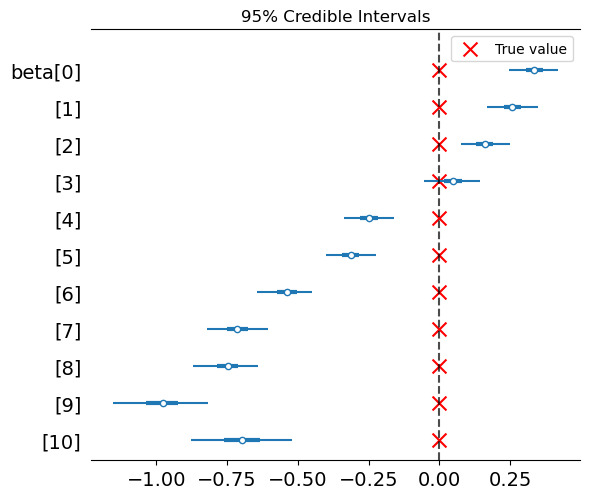

In [15]:
true_beta_params = beta_mat[:,k_infector-1][np.arange(n_pathogens) != k_infector-1]
print(f"True beta coefficients: {true_beta_params}")
axes = az.plot_forest(idata, var_names=["beta"], 
                      hdi_prob=0.95, combined=True)
ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes
plt.axvline(0, color='black', linestyle='--', alpha=0.7)
yticks = ax.get_yticks()
yticklabels = [label.get_text() for label in ax.get_yticklabels()]
for i, label in enumerate(yticklabels):
    idx = int(label.split('[')[-1].split(']')[0])
    val = true_beta_params[idx]
    ax.scatter(val, yticks[i], marker='x', color='red', s=100, label='True value' if i == 0 else "")
if beta_mat.size > 0:
    ax.legend(loc='best')
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

## Compare seroprevalence proportion

Number of individuals in the subsample: 999
Ground truth effect sizes for pathogen 2: [ 0.          0.          0.          0.          1.15859558  0.
  0.          0.          0.          0.          0.         -0.47494531]
Estimated effect sizes for pathogen 2: covariate
serostatus_2    -0.151014
serostatus_3    -0.161473
serostatus_4    -0.028195
serostatus_5    -0.064126
serostatus_6     0.146684
serostatus_7     0.016292
serostatus_8    -0.028843
serostatus_9     0.074500
serostatus_10    0.020040
serostatus_11   -0.235103
serostatus_12   -0.026069
dtype: float64
Confidence intervals for pathogen 2:                95% lower-bound  95% upper-bound
covariate                                      
serostatus_2         -0.418284         0.116255
serostatus_3         -0.443444         0.120499
serostatus_4         -0.290572         0.234182
serostatus_5         -0.372072         0.243821
serostatus_6         -0.135296         0.428663
serostatus_7         -0.278058         0.310642
sero

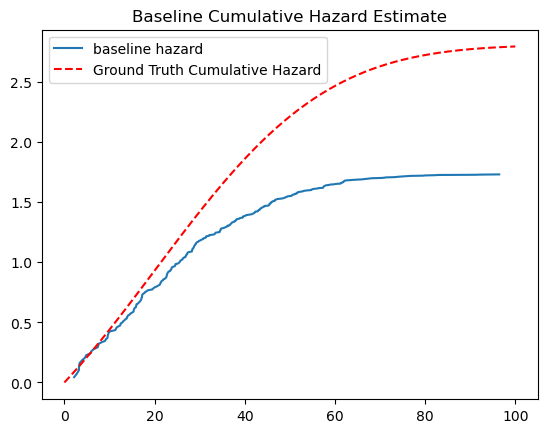

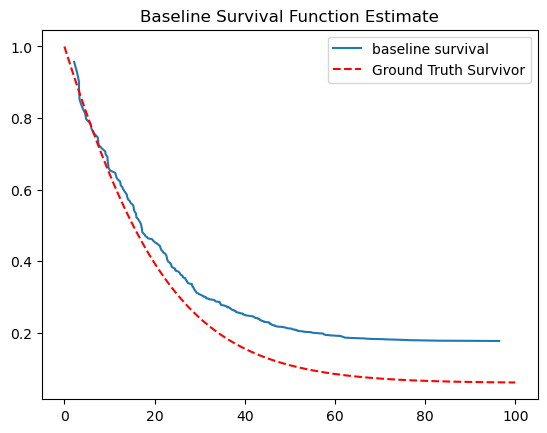

In [ ]:
#########################
k = 2
n_people_subsample = 1000
#########################

regression_df = simulation_to_regression_df(
    simulation_to_validate,
    k_infector = k,
    t_max = t_max
)
regression_df_for_pathogen_k_subsampled = regression_df_for_pathogen_k[regression_df_for_pathogen_k["individual"]<n_people_subsample]

# Instantiate the CoxTimeVaryingFitter
ctv = CoxTimeVaryingFitter()

# Fit the model
ctv.fit(
    regression_df_for_pathogen_k_subsampled,
    id_col = "individual",
    start_col="start_time",
    stop_col="stop_time",
    event_col="event"
)


print(f"Number of individuals in the subsample: {len(regression_df_for_pathogen_k_subsampled['individual'].unique())}")
print(f"Ground truth effect sizes for pathogen {k}: {np.log(interaction_mat[:, k])}")
print(f"Estimated effect sizes for pathogen {k}: {ctv.params_}")
print(f"Confidence intervals for pathogen {k}: {ctv.confidence_intervals_}")

# Print summary
# ctv.print_summary()

# Plot baseline cumulative hazard with ground truth cumulative hazard
ax = ctv.baseline_cumulative_hazard_.plot(title="Baseline Cumulative Hazard Estimate")
t_grid = np.linspace(0, t_max, 500)
# Ground truth cumulative hazard: -log(S(t))
S_theoretical = survivor_list[k](t_grid)
cumhaz_theoretical = - np.log(S_theoretical)
ax.plot(t_grid, cumhaz_theoretical, label='Ground Truth Cumulative Hazard', color='red', linestyle='--')
ax.legend()

# Plot baseline survival with ground truth survivor
ax2 = ctv.baseline_survival_.plot(title="Baseline Survival Function Estimate")
ax2.plot(t_grid, S_theoretical, label='Ground Truth Survivor', color='red', linestyle='--')
ax2.legend()

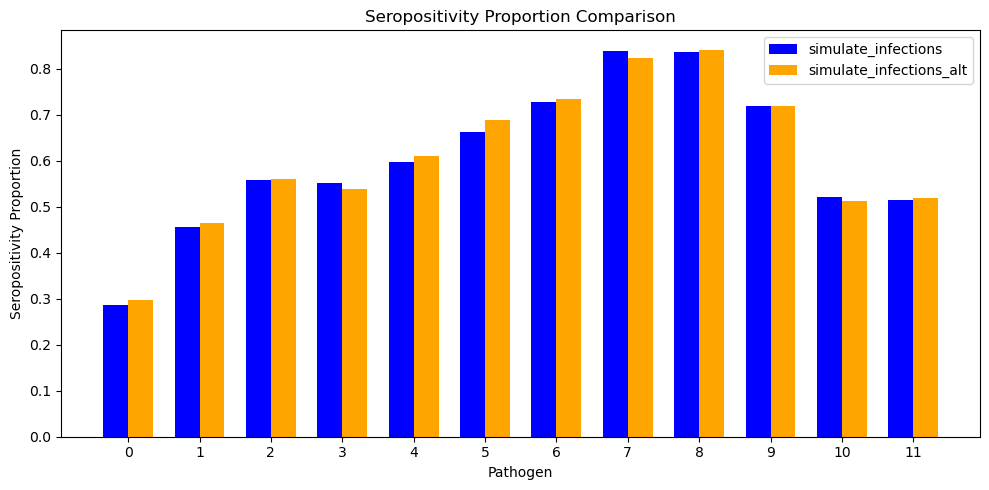

In [ ]:
seroprop = survey_df_long.groupby('pathogen')['serostatus'].mean()
seroprop_alt = survey_df_long_discrete.groupby('pathogen')['serostatus'].mean()
# Plot grouped bar chart for seropositivity proportions from both simulations
x = np.arange(n_pathogens)
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, seroprop.values, width, label='simulate_infections', color='blue')
plt.bar(x + width/2, seroprop_alt.values, width, label='simulate_infections_alt', color='orange')
plt.ylabel('Seropositivity Proportion')
plt.xlabel('Pathogen')
plt.title('Seropositivity Proportion Comparison')
plt.xticks(x, [f'{k}' for k in range(n_pathogens)])
plt.legend()
plt.tight_layout()
plt.show()


## Kaplan-Meier looking at first event time

In [ ]:
# For each individual, find the first seroconversion event (if any)
def get_first_seroconversion(sim_df: pd.DataFrame, t_end: float) -> pd.DataFrame:
    sero = sim_df[sim_df['event'] == 'seroconversion']
    # Sort by time to ensure first event is picked
    sero_sorted = sero.sort_values(['individual', 'time'])
    # Get first seroconversion per individual
    first_sero = sero_sorted.groupby('individual', as_index=False).first()
    # Prepare output DataFrame
    result = pd.DataFrame({'individual': np.arange(n_people)})
    result = result.merge(
        first_sero[['individual', 'time', 'pathogen']],
        on='individual',
        how='left'
    )
    # Fill missing with t_end and NA for pathogen
    result['time'] = result['time'].fillna(t_end)
    result['pathogen'] = result['pathogen']
    return result

first_seroconversion_df = get_first_seroconversion(simulate_infections_df, t_end=100)
first_seroconversion_df

,individual,time,pathogen
0,0,38.541990,6.0
1,1,96.848270,10.0
2,2,76.743643,7.0
3,3,63.417365,7.0
4,4,17.793485,2.0
...,...,...,...
995,995,14.719704,0.0
996,996,92.036311,6.0
997,997,16.537812,3.0
998,998,97.602586,9.0


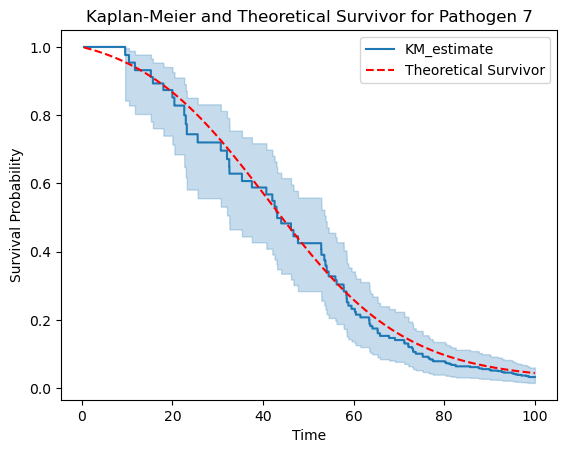

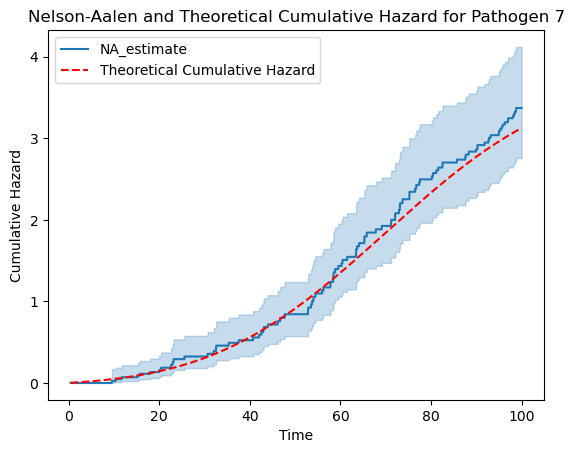

In [ ]:
from lifelines import KaplanMeierFitter, NelsonAalenFitter

k = 7

# left truncation times (birth times)
entry = birth_times

# Time when subject exited the study (either event or censoring)
exit = first_seroconversion_df['time'].values

# Whether the event (e.g., death) occurred (1) or was censored (0)
event_observed = (first_seroconversion_df['pathogen'].values)==k

kmf = KaplanMeierFitter()
kmf.fit(durations=exit, event_observed=event_observed, entry=entry)

kmf.plot_survival_function()

# Plot the theoretical survivor function for pathogen k
t_grid = np.linspace(entry.min(), exit.max(), 500)
S_theoretical = survivor_list[k](t_grid)
plt.plot(t_grid, S_theoretical, label='Theoretical Survivor', color='red', linestyle='--')
plt.legend()
plt.title(f'Kaplan-Meier and Theoretical Survivor for Pathogen {k}')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Instantiate the Nelson-Aalen fitter
plt.figure()
naf = NelsonAalenFitter()

# Fit the model using the same durations and event_observed as Kaplan-Meier
naf.fit(durations=exit, event_observed=event_observed, entry=entry)

# Plot the cumulative hazard estimate
naf.plot_cumulative_hazard()

# Optionally, overlay the theoretical cumulative hazard for comparison
t_grid = np.linspace(entry.min(), exit.max(), 500)
cumhaz_theoretical = -np.log(survivor_list[k](t_grid))  # Ground truth cumulative hazard
plt.plot(t_grid, cumhaz_theoretical, label='Theoretical Cumulative Hazard', color='red', linestyle='--')
plt.legend()
plt.title(f'Nelson-Aalen and Theoretical Cumulative Hazard for Pathogen {k}')
plt.xlabel('Time')
plt.ylabel('Cumulative Hazard')
plt.show()

# frailty

In [ ]:
from typing import Callable, List, Union, Optional

def simulate_infections_with_frailties(
        n_people: int,
        n_pathogens: int,
        foi_list: List[Callable[[Union[float, np.ndarray]], np.ndarray]],
        interaction_mat: Optional[np.ndarray],
        t_max: float = 100,
        birth_times: Optional[np.ndarray] = None,
        frailties: Optional[np.ndarray] = None,
        max_fois: Optional[np.ndarray] = None,
        random_seed: Optional[int] = None
    ) -> pd.DataFrame:
    """
    Simulate infections using thinning of Poisson process.
    Parameters:
        n_people (int): Number of individuals.
        n_pathogens (int): Number of pathogens.
        fois (Callable[[float], np.ndarray]): Function that returns the forces of infection at time t for each pathogen.
        interaction_mat (Optional[np.ndarray]): Interaction matrix for pathogens. The k,l entry indicates the effect of pathogen k on pathogen l.
        birth_times (Optional[np.ndarray]): Birth times for each individual. If None, individuals are assumed to be born at time 0.
        t_max (float): Maximum time for the simulation.
        max_fois (Optional[np.ndarray]): Maximum force of infection values for each pathogen.
        random_seed (Optional[int]): Random seed for reproducibility.
    
    """
    if birth_times is None:
        birth_times = np.zeros(n_people, dtype=float)
    if frailties is None:
        frailties = np.ones(n_people, dtype=float)
    if random_seed is not None:
        np.random.seed(random_seed)
    if interaction_mat is None:
        interaction_mat = np.ones((n_pathogens, n_pathogens))
    if max_fois is None:
        t_grid = np.linspace(0, t_max, 1000)
        max_fois = np.array([foi_list[k](t_grid).max() for k in range(n_pathogens)])
        max_fois *= 1.1 # leeway for discretization errors
    assert max_fois is not None  # for type checkers
    
    infection_times = []
    for i in range(n_people):
        birth_time = birth_times[i]
        frailty = frailties[i]
        infection_times.append((birth_time, 'birth', i, None))
        t_current = birth_time
        infection_status = np.zeros(n_pathogens, dtype=bool)  # Track infections for each pathogen
        susceptibility_factors = np.prod(interaction_mat[infection_status], axis=0) * frailty
        while True: #simulate until t_max reached or np.all(infection_status)
            proposal_indices = np.where(infection_status == 0)[0] # Indices of pathogens not yet infected
            proposal_times = np.full(len(proposal_indices), t_current, dtype=float) # Initialize proposal times for pathogens not yet infected
            earliest_accepted_proposal = np.inf
            earliest_accepted_proposal_index = None
            while proposal_indices.size > 0:
                # generate proposal times for each pathogen
                proposal_times += np.random.exponential(
                    1 / max_fois[proposal_indices] / susceptibility_factors[proposal_indices],
                    size=len(proposal_indices)
                )
                #thinning step
                accept_probs = np.array(
                    [foi_list[k](proposal_times[j]) / max_fois[k] for j, k in enumerate(proposal_indices)]
                )
                accept_mask = np.random.uniform(0, 1, size=len(proposal_indices)) < accept_probs
                #updates
                if np.any(accept_mask):
                    if proposal_times[accept_mask].min() < earliest_accepted_proposal:
                        # Update the earliest accepted proposal if a new one is found
                        accepted_proposal_indices = proposal_indices[accept_mask]
                        accepted_proposal_times = proposal_times[accept_mask]
                        earliest_accepted_proposal_index = accepted_proposal_indices[np.argmin(accepted_proposal_times)]
                        earliest_accepted_proposal = accepted_proposal_times.min()
                # continue generating for pathogens that still have a chance to infect earlier than the current earliest
                continue_mask = proposal_times < min(earliest_accepted_proposal, t_max)
                proposal_indices = proposal_indices[continue_mask]
                proposal_times = proposal_times[continue_mask]
            if earliest_accepted_proposal > t_max:
                break
            else:
                assert earliest_accepted_proposal_index is not None
            t_current = earliest_accepted_proposal
            k = earliest_accepted_proposal_index
            infection_times.append((t_current, 'seroconversion', i, k))
            infection_status[k] = 1
            if np.all(infection_status):
                break
            susceptibility_factors = np.prod(interaction_mat[infection_status], axis=0) * frailty
    return pd.DataFrame(infection_times, columns=['time', 'event', 'individual', 'pathogen'])

In [ ]:
frailties = np.exp(np.random.normal(0, 0.5, size=n_people))  # Random frailties for individuals
simulate_infections_with_frailties_df = simulate_infections_with_frailties(n_people, n_pathogens, foi_list, interaction_mat, t_max=100, birth_times=birth_times, frailties=frailties, random_seed=42)

In [ ]:
survey_with_frailties_df_long = simulation_to_survey_long(
    simulate_infections_with_frailties_df,
    survey_times=100
)
survey_with_frailties_df_wide = survey_long_to_wide(survey_with_frailties_df_long)

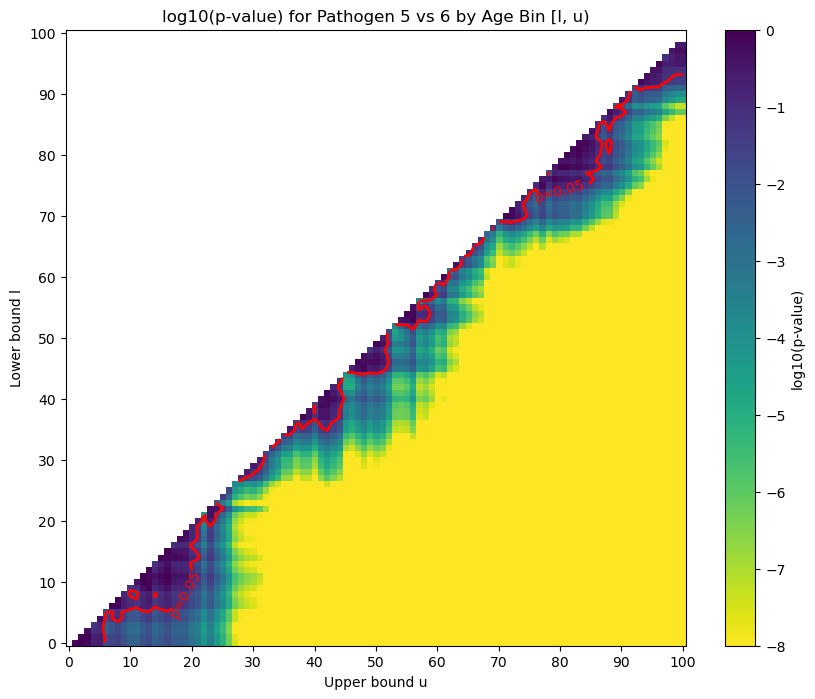

In [ ]:
k1, k2 = 5,6  # Pathogen indices to compare
max_age = int(np.ceil(birth_times.max()))
min_age = int(np.floor(birth_times.min()))
heatmap_size = max_age - min_age + 1


# Precompute birth times for all individuals
individual_birth_times = survey_with_frailties_df_wide.merge(
    pd.DataFrame({'individual': np.arange(len(birth_times)), 'birth_time': birth_times}),
    on='individual'
)

# Precompute contingency tables for each [t, t+1) bin
contingency_tables = []
for t in range(min_age, max_age):
    in_bin = (individual_birth_times['birth_time'] >= t) & (individual_birth_times['birth_time'] < t + 1)
    filtered = individual_birth_times[in_bin]
    if (f'serostatus_{k1}' in filtered.columns and
        f'serostatus_{k2}' in filtered.columns and
        filtered[f'serostatus_{k1}'].nunique() > 1 and
        filtered[f'serostatus_{k2}'].nunique() > 1):
        ct = pd.crosstab(filtered[f'serostatus_{k1}'], filtered[f'serostatus_{k2}'])
        # Ensure 2x2 shape for summing later
        ct = ct.reindex(index=[0,1], columns=[0,1], fill_value=0)
        contingency_tables.append(ct.values)
    else:
        contingency_tables.append(np.zeros((2,2), dtype=int))


pval_matrix = np.full((heatmap_size, heatmap_size), np.nan)

# Efficiently sum contingency tables for each [l, u) bin
for l in range(min_age, max_age):
    cumsum = np.zeros((2,2), dtype=int)
    for u in range(l + 1, max_age + 1):
        cumsum += contingency_tables[u - min_age - 1]  # [l, u): add bin u-1
        if cumsum.sum() < 5 or np.any(cumsum.sum(axis=0) == 0) or np.any(cumsum.sum(axis=1) == 0):
            continue
        tbl = Table2x2(cumsum)
        p_value = tbl.test_nominal_association().pvalue
        pval_matrix[l - min_age, u - min_age] = p_value

log_pval_matrix = np.log10(pval_matrix)
log_pval_matrix_clipped = np.where(np.isnan(log_pval_matrix), np.nan, np.maximum(log_pval_matrix, -8))

plt.figure(figsize=(10, 8))
im = plt.imshow(log_pval_matrix_clipped, origin='lower', aspect='auto', cmap='viridis_r', vmin=-8, vmax=0)
plt.colorbar(im, label='log10(p-value)')
plt.xlabel('Upper bound u')
plt.ylabel('Lower bound l')
plt.title(f'log10(p-value) for Pathogen {k1} vs {k2} by Age Bin [l, u)')

# Draw contour for p = 0.05
from matplotlib import ticker
X, Y = np.meshgrid(np.arange(pval_matrix.shape[1]), np.arange(pval_matrix.shape[0]))
contour = plt.contour(
    X, Y, pval_matrix, levels=[0.05], colors='red', linewidths=2, origin='lower'
)
plt.clabel(contour, fmt={0.05: 'p=0.05'}, colors='red', fontsize=10)

# Ticks every 10 years
tick_step = 10
xtick_locs = np.arange(0, heatmap_size, tick_step)
ytick_locs = np.arange(0, heatmap_size, tick_step)
plt.xticks(xtick_locs, (min_age + xtick_locs).astype(int))
plt.yticks(ytick_locs, (min_age + ytick_locs).astype(int))

plt.show()

In [ ]:
import numpy as np
array = np.array([[1, 2], [4, 5], [7, 8]])
array[1]
array.shape

(3, 2)